We will apply our estimation algorithm to select incorrectly-labeled samples from a noisy dataset. We will show that by apply our algorithm to estimate the fine-tuning losses on randomly sampled subsets, the random ensemble scores (as the average performance over subsets containing one group of samples) eventually separate the noisy and correct examples. 

### Generate a synthetic noisy dataset

In this example, we will work on a synthetic dataset of addition tasks: given two numbers as sequences of digits, predict the addition result of the two numbers. Besides the output, we also train the model to predict the intermediate addition results at each step. We consider a five-digit addition. The input and output would look like the following:

$$
\text{Input: } 6 7 0 1 3 + 2 3 9 2 4 
$$

$$
\text{Output: } 0 7 | 0 3 7 | 0 9 3 7 | 1 0 9 3 7 | 9 0 9 3 7
$$

We will generate a dataset with 300 correctly labeled training samples and 200 randomly labeled samples. 

In [1]:
from copy import deepcopy
import numpy as np
import os
import pandas as pd

In [ ]:
# Generate a noisy synthetic addition dataset


# define constants
length = 5 # input instance length 5
allow_carry = True
data_size = 100000 # Let's generate 10000 examples of addition
file_dir = "./data/addition/" # folder to save the generated samples
if not os.path.exists(file_dir):
    os.makedirs(file_dir)


# main function of generating addition results
def addition(digits1, digits2):
    intermediate_steps = []

    digits1 = digits1[::-1]
    digits2 = digits2[::-1]
    digits = digits1 + digits2
    carry = False
    for i in range(len(digits)):
        tmp_carry = False
        if digits[i] >= 10:
            if i == len(digits) - 1:
                digits = np.append(digits, [1])
            else:
                digits[i+1] += 1
            digits[i] -= 10
            carry = True
            tmp_carry = True
        intermediate_steps.append(
           [1 if tmp_carry else 0] + list(deepcopy(digits[:i+1][::-1]))
        )
    digits1 = digits1[::-1]
    digits2 = digits2[::-1]
    return digits[::-1], carry, intermediate_steps

# function for generating random response (noisy samples)
def generate_random_results(outputs, intermediate_steps):
    noisy_outputs = np.random.randint(0, 10, size=outputs.shape)
    noisy_intermediate_steps = []
    for steps in intermediate_steps:
        noisy_steps = np.random.randint(0, 10, size=np.array(steps).shape)
        noisy_intermediate_steps.append(noisy_steps)
    return noisy_outputs, noisy_intermediate_steps

# First let's generate a set of correct examples
file_name = os.path.join(file_dir, f"digit_{length}_carry_{allow_carry}.csv")
df = None
for _ in range(data_size):

    # sample digits
    digits1 = np.random.randint(0, 10, length)
    while digits1[0] == 0:
        digits1 = np.random.randint(0, 10, length)

    digits2 = np.random.randint(0, 10, length)
    while digits2[0] == 0:
        digits2 = np.random.randint(0, 10, length)

    # perform addition 
    assert allow_carry is True
    output_digits, carry, intermediate_steps = addition(digits1, digits2)

    # save the samples to a csv file for future loading
    input = " ".join([str(int(i)) for i in digits1]) + " + " + " ".join([str(int(i)) for i in digits2])
    instance = {
        "input": input,
    }
    output = " ".join([str(int(i)) for i in output_digits])
    instance.update({
        "output": output,
    })
    records = intermediate_steps # also saves their intermediate steps
    for k, record in enumerate(records):
        if k == len(records) - 1: continue # skip the last one
        instance.update({
            f"step_{k}": " ".join([str(int(i)) for i in record]), # count it backwards
        })
    
    for key, val in instance.items():
        instance[key] = [val, ]
    tmp_df = pd.DataFrame(instance)
    df = pd.concat([df, tmp_df], ignore_index=True) if df is not None else tmp_df

    if len(df) == 1000:
        if not os.path.exists(file_name):
            df.to_csv(file_name)
        else:
            result_df = pd.read_csv(file_name, index_col=0)
            result_df = pd.concat([result_df, df], ignore_index = True)
            result_df.to_csv(file_name)       
            if result_df.shape[0] > data_size:
                exit() 
        df = None

# Then Let's generate noisy examples and store them in another file
file_name = os.path.join(file_dir, f"digit_{length}_noisy.csv")
df = None
for _ in range(data_size):

    # sample digits
    digits1 = np.random.randint(0, 10, length)
    while digits1[0] == 0:
        digits1 = np.random.randint(0, 10, length)

    digits2 = np.random.randint(0, 10, length)
    while digits2[0] == 0:
        digits2 = np.random.randint(0, 10, length)

    # add
    output_digits, carry, intermediate_steps = addition(digits1, digits2)
    if (not allow_carry) and carry:
        while carry:
            digits1 = np.random.randint(0, 6, length)
            while digits1[0] == 0:
                digits1 = np.random.randint(0, 6, length)

            digits2 = np.random.randint(0, 10, length)
            while digits2[0] == 0:
                digits2 = np.random.randint(0, 10, length)

            # add
            output_digits, carry, intermediate_steps = addition(digits1, digits2)   

    # generate noisy results
    output_digits, intermediate_steps = generate_random_results(output_digits, intermediate_steps)

    # save
    input = " ".join([str(int(i)) for i in digits1]) + " + " + " ".join([str(int(i)) for i in digits2])
    instance = {
        "input": input,
    }
    output = " ".join([str(int(i)) for i in output_digits])
    instance.update({
        "output": output,
    })
    records = intermediate_steps
    for k, record in enumerate(records):
        if k == len(records) - 1: continue # skip the last one
        instance.update({
            f"step_{k}": " ".join([str(int(i)) for i in record]), # count it backwards
        })
    
    for key, val in instance.items():
        instance[key] = [val, ]
    tmp_df = pd.DataFrame(instance)
    df = pd.concat([df, tmp_df], ignore_index=True) if df is not None else tmp_df

    if len(df) == 1000:
        if not os.path.exists(file_name):
            df.to_csv(file_name)
        else:
            result_df = pd.read_csv(file_name, index_col=0)
            result_df = pd.concat([result_df, df], ignore_index = True)
            result_df.to_csv(file_name)       
            if result_df.shape[0] > data_size:
                exit() 
        df = None

Before loading our generated data, we will train a GPT-2 style tokenizer for this dataset.

In [ ]:
from datasets import Dataset
from transformers import GPT2TokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from format_utils import generate_simple_algorithm_example

# we will load generated data and train a tokenizer on the data
file_name = f"./data/addition/digit_5_carry_True.csv"
instance_df = pd.read_csv(file_name, index_col=0)
num_of_instances = instance_df.shape[0]
train_data = []

# Create a dataset containing all the data
def gen():
    for i in range(num_of_instances):
        yield generate_simple_algorithm_example(instance_df, i, k=0)

dataset = Dataset.from_generator(generator=gen)

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["input"]

# Train a BPE tokenizer for the generated samples
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

trainer = trainers.BpeTrainer(vocab_size=250, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)
if not os.path.exists("./tokenizers/gpt2_addition"):
    os.makedirs("./tokenizers/gpt2_addition")
wrapped_tokenizer.save_pretrained("./tokenizers/gpt2_addition")

('./tokenizers/gpt2_addition/tokenizer_config.json',
 './tokenizers/gpt2_addition/special_tokens_map.json',
 './tokenizers/gpt2_addition/vocab.json',
 './tokenizers/gpt2_addition/merges.txt',
 './tokenizers/gpt2_addition/added_tokens.json',
 './tokenizers/gpt2_addition/tokenizer.json')

Now with generated data and tokenizers, let's load the dataset and train a GPT-2 model on the dataset from scratch.

In [ ]:
import math
import os
import torch
import datasets

import pandas as pd
import numpy as np

from collections import defaultdict
from format_utils import load_algorithmic_dataset_with_intermediate_steps
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, get_scheduler
from torch.utils.data import DataLoader

In [ ]:
# load datasets
tokenizer = AutoTokenizer.from_pretrained("./tokenizers/gpt2_addition", use_fast=True)
if tokenizer.pad_token_id is None:
    if tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    else:
        tokenizer.pad_token_id = 0

# First we load the clean data (300 clean examples for training, 2000 validation and test samples)
algorithm, data_dir, train_size = "addition", "digit_5_carry_True", 300
train_dataset, valid_dataset, test_dataset, output_columns = load_algorithmic_dataset_with_intermediate_steps(
    algorithm, data_dir, train_size, valid_size=10000, test_size=10000, only_ouptut=False
)

# Then we load the noisy dataset (200 noisy examples into the training set)
noisy_data_dir = "digit_5_noisy"; noisy_train_size = 200
noisy_train_dataset, _, _, output_columns = load_algorithmic_dataset_with_intermediate_steps(
    algorithm, noisy_data_dir, noisy_train_size, 100, 100, only_ouptut=False
)
train_dataset = datasets.concatenate_datasets([train_dataset, noisy_train_dataset])

print("Train size: {}, Valid size: {}, Test size: {}".format(len(train_dataset), len(valid_dataset), len(test_dataset)))

# initialize data loader (max length to 64 since we are using length 5 addition)
collator = CLMCollator(tokenizer, max_length=64, return_indices=True, output_columns=output_columns)
train_data_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collator, shuffle=False)
valid_data_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=collator, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collator, shuffle=False)

train size: 300, valid size: 10000, test size: 10000
train size: 200, valid size: 100, test size: 100
Train size: 500, Valid size: 10000, Test size: 10000


### Train a model on all the training data as the meta-initialization

Recall in our algorithm, we conduct first-order approximation from a meta-initialization, obtained from multitask training on all tasks. In this case, we simply view all the training samples as all tasks and train one model on the whole training dataset. 

We will use a two-layer GPT-2 style model. In the following, we conventionally define the model, tokenizer, optimizer, and learning rate schedule. 

In [5]:
# initialize model
def load_model(model_name, if_pretrained=True, num_layers=12, tokenizer_dir="gpt2_addition"):
    """
    Return the model and tokenizer
    """
    if model_name in ['gpt2', "gpt2-medium", "gpt2-large", "gpt2-xl",]:
        if if_pretrained:
            model = AutoModelForCausalLM.from_pretrained(model_name, 
                        # torch_dtype=torch.float16, 
                        #  ignore_mismatched_sizes=True
                        )
            tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False) 
        else:
            tokenizer = AutoTokenizer.from_pretrained(f"./tokenizers/{tokenizer_dir}", use_fast=True) 
            config = AutoConfig.from_pretrained("gpt2")
            config.n_layer = num_layers
            config.vocab_size = tokenizer.vocab_size
            print("Num layers: {} Vocab size: {}".format(config.n_layer, config.vocab_size))
            model = AutoModelForCausalLM.from_config(config)
            
        if tokenizer.pad_token_id is None:
            if tokenizer.eos_token_id is not None:
                tokenizer.pad_token_id = tokenizer.eos_token_id
            else:
                tokenizer.pad_token_id = 0

    return model, tokenizer

model, tokenizer = load_model("gpt2", if_pretrained=False, num_layers=2, tokenizer_dir="gpt2_addition")
device = torch.device(f"cuda")
model.to(device)
split_attention = False

metrics = defaultdict(list)

# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "layer_norm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 1e-4,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-3)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = len(train_data_loader)
max_train_steps = 10000
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=10000,
    num_training_steps=100000,
)

Num layers: 2 Vocab size: 25


Then, we define the training and evaluation loop. We will train the model for 10000 steps (until the trianing loss converges). We will observe that the model cannot fully predict the validation samples due to the existence of noisy training samples. 

In [ ]:
# Train
from compute_metrics import exact_match_score, accuracy_score, metric_max_over_ground_truths, edit_distance_score, compute_accuracy, MetricTracker

def prepare_inputs(batch, device):
    for t in batch:
        if torch.is_tensor(batch[t]):
            batch[t] = batch[t].to(device)
    return batch

train_metrics = MetricTracker('loss')
valid_metrics = {f"column_{task}": MetricTracker('loss', 'accuracy', 'edit_distance') for task in output_columns}
valid_metrics['average'] = MetricTracker('loss', 'accuracy', 'edit_distance')

@torch.no_grad()
def valid_epoch():
    """
    Validate after training an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains information about validation
    """
    model.eval()

    log = {}
    for task_name in valid_metrics.keys():
        valid_metrics[task_name].reset()
    for step, batch in enumerate(valid_data_loader):
        inputs_batch = {k: v for k, v in batch.items() if (k not in ["inputs", "steps", "indexes", "task_indices"])}
        inputs_batch = prepare_inputs(inputs_batch, device)
        outputs = model(**inputs_batch)
        if step == 0:
            print("inputs", tokenizer.batch_decode(batch["input_ids"][:8], skip_special_tokens=True))

        """
        generate response
        """
        # Get the labels
        gold_answers = batch["labels"].clone()
        gold_answers[gold_answers == -100] = tokenizer.pad_token_id
        output_len = (gold_answers != tokenizer.pad_token_id).sum(dim=1).max().item()
        gold_answers = tokenizer.batch_decode(gold_answers, skip_special_tokens=True)

        # get only the inputs
        inputs = batch["input_ids"].clone()
        inputs[batch["labels"] != -100] = tokenizer.pad_token_id
        inputs = tokenizer.batch_decode(inputs, skip_special_tokens=True)
        tokenizer.padding_side = 'left'
        inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True)
        tokenizer.padding_side = 'right'
        inputs = prepare_inputs(inputs, device)
        if "position_ids" in batch:
            inputs["position_ids"] = torch.zeros_like(inputs["input_ids"])
        generated = model.generate(**inputs, 
                                        max_new_tokens=64, 
                                        pad_token_id=tokenizer.pad_token_id)

        # remove the given prompt in the output
        input_len = inputs["input_ids"].shape[1]
        generated[:, :input_len] = tokenizer.pad_token_id
        generated[:, input_len+output_len:] = tokenizer.pad_token_id
        pred_answers = tokenizer.batch_decode(generated, skip_special_tokens=True)
        gold_answers = [[answer] for answer in gold_answers]
        if step == 0:
            print("gold_answers", gold_answers[:8])
            print("pred_answers", pred_answers[:8])
        
        metrics = compute_accuracy(pred_answers, gold_answers, task_indices=batch["task_indices"])

        for column in output_columns:
            task_name = f"column_{column}"
            valid_metrics[task_name].update('loss', outputs.loss.item(), n=len(batch["labels"]))
            valid_metrics[task_name].update('accuracy', metrics[f"{task_name}_accuracy"], n=metrics[f"{task_name}_num_samples"])
            valid_metrics[task_name].update('edit_distance', metrics[f"{task_name}_edit_distance"], n=metrics[f"{task_name}_num_samples"])

            valid_metrics['average'].update('loss', outputs.loss.item(), n=len(batch["labels"]))
            valid_metrics['average'].update('accuracy', metrics[f"{task_name}_accuracy"], n=metrics[f"{task_name}_num_samples"])
            valid_metrics['average'].update('edit_distance', metrics[f"{task_name}_edit_distance"], n=metrics[f"{task_name}_num_samples"])
    
    for column in output_columns:
        task_name = f"column_{column}"
        task_log = valid_metrics[task_name].result()
        log.update({task_name + '_' + k : v for k, v in task_log.items()})
    avg_log = valid_metrics['average'].result()
    log.update({k : v for k, v in avg_log.items()})
    return log

def train_epoch(epoch):
    """
    Training logic for an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    train_metrics.reset()
    for step, batch in enumerate(train_data_loader):
        inputs_batch = {k: v for k, v in batch.items() if (k not in ["inputs", "steps", "indexes", "task_indices"])}
        inputs_batch = prepare_inputs(inputs_batch, device)
        outputs = model(**inputs_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        # update training metrics
        train_metrics.update('loss', loss.item())

    log = train_metrics.result()

    if epoch % 40 == 0:
        val_log = valid_epoch()
        log.update(**{'val_'+k : v for k, v in val_log.items()})

    return log


In [ ]:
checkpoint_dir = os.path.join("saved", "gpt2_layer_2_addition_length_5_train_size_300_noisy_sample_200")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_accuracy = 0
for epoch in range(num_train_epochs):
    result = train_epoch(epoch)
    log = {'epoch': epoch}
    log.update(result)

    # print logged informations to the screen
    for key, value in log.items():
        print('    {:15s}: {}'.format(str(key), value))
    
    if ('val_accuracy' in log) and (best_accuracy < log['val_accuracy']):
        state = model.state_dict()
        best_path = os.path.join(checkpoint_dir, f'model_best.pth')
        torch.save(state, best_path)

### Gradient evaluation at the meta-initialization
Recall that the estimation of fine-tuning performance corresponds to solving logistic regression with the gradients as features. Next, we will generate gradients on the model we just trained. We will show that using this model with not perfect accuracy, our estimation method can be used to select correct and noisy examples.

In [11]:
# Evaluate the gradients of training samples at the initialization and project the gradients

# load the best trained model
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'model_best.pth')))
gradient_dim = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        gradient_dim += param.numel()

gradients_dir = f"./gradients/{algorithm}_{data_dir}_noisy_samples"
if not os.path.exists(gradients_dir):
    os.makedirs(gradients_dir)

# create_projection matrix
np.random.seed(0)
project_dim = 200
matrix_P = (2 * np.random.randint(2, size=(gradient_dim, project_dim)) - 1).astype(np.float32)
matrix_P *= 1 / np.sqrt(project_dim)
project_matrix = matrix_P
print("Creating a projection matrix of size: {} x {}".format(gradient_dim, project_dim))


def get_trainable_parameters(model):
    return [param for param in model.parameters() if param.requires_grad]

/tmp/ipykernel_60594/2046500781.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'model_best.pth')))


Creating a projection matrix of size: 14982912 x 200


In [ ]:
# Start to collect gradients
model.eval()
for batch_idx, batch in enumerate(train_data_loader):
    inputs_batch = {k: v for k, v in batch.items() if (k not in ["inputs", "steps", "indexes", "task_indices"])}
    inputs_batch = prepare_inputs(inputs_batch, device)
    outputs = model(**inputs_batch)
    print(outputs.loss)

    gradients = []
    logits = outputs.logits[..., :-1, :].contiguous()
    labels = inputs_batch["labels"][..., 1:].contiguous()
    for i in range(len(labels)):
        tmp_mask = labels[i] != -100
        tmp_logits = logits[i][tmp_mask]
        tmp_probs = torch.softmax(tmp_logits, dim=-1)
        tmp_labels = labels[i][tmp_mask]

        tmp_outputs = tmp_probs[range(tmp_probs.size(0)), tmp_labels] - 1e-3
        tmp_outputs = torch.log(tmp_outputs/(1-tmp_outputs+1e-10))
        tmp_loss = tmp_outputs.mean()

        tmp_gradients = torch.autograd.grad(tmp_loss, get_trainable_parameters(model), retain_graph=True, create_graph=False)
        tmp_gradients = torch.cat([gradient.reshape(-1) for gradient in tmp_gradients]).cpu().numpy() # flatten gradients
        tmp_gradients = (tmp_gradients.reshape(1, -1) @ project_matrix).flatten()
        gradients.append(tmp_gradients)
    gradients = np.array(gradients)
    np.save(f"{gradients_dir}/train_batch_{batch_idx}_gradients.npy", gradients)

### Logistic regression using gradients as features

With the gradients, we will apply the first-order approximation to estimate the model fine-tuned parameters on a subset of data. 

- We will show that, on the subset of more correct examples, the estimated loss is low; Otherwise, the estimated loss is high.

- Then, we conduct random sampling over subsets of data groups, by viewing 25 samples as one group. We will show that the random ensemble scores for each group clearly separate the noisy and correct samples. 

Notice that in the logistic regression, setting the regularization parameter is crucial in order to control the norm of model fine-tuned weights. It usually needs to be tuned so that the estimted loss is in a reasonable range.

In [ ]:
from sklearn.linear_model import LogisticRegression

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'model_best.pth')))
state_dict = {
    key: val.clone() for key, val in model.state_dict().items()
    }

# functions for first-order approximation
def generate_state_dict(model, state_dict, coef, device, removing_keys = ["wte", "wpe", "lm_head"]):
    # reshape coef
    new_state_dict = {}; cur_len = 0
    for key, param in model.named_parameters():
        if not param.requires_grad: continue
        param_len = param.numel()
        if any([rkey in key for rkey in removing_keys]):
            new_state_dict[key] = state_dict[key].clone()
        else:
            new_state_dict[key] = state_dict[key].clone() + \
                torch.FloatTensor(coef[cur_len:cur_len+param_len].reshape(param.shape)).to(device)
        cur_len += param_len
    return new_state_dict

def add_result_to_csv(result_datapoint, file_name):
    for key, val in result_datapoint.items():
        result_datapoint[key] = [val, ]
    
    if os.path.exists(file_name):
        result_df = pd.read_csv(file_name, index_col=0)
        tmp_df = pd.DataFrame(result_datapoint)
        result_df = pd.concat([result_df, tmp_df], ignore_index = True)
        result_df.to_csv(file_name)
    else:
        result_df = pd.DataFrame(result_datapoint)  
        result_df.to_csv(file_name)   

def first_order_approximation(data_idxes, batch_size=64):
    # collect gradients for the subset
    gradients = []
    for idx in data_idxes:
        gradient_file_idx = idx // batch_size
        gradient_file = f"{gradients_dir}/train_batch_{gradient_file_idx}_gradients.npy"
        tmp_gradients = np.load(gradient_file)
        gradients.append(tmp_gradients[idx % batch_size])
    gradients = np.array(gradients)

    # randomly assign labels as 0 or 1
    labels = np.random.binomial(n=1, p=0.7, size=gradients.shape[0])

    # reverse the gradients for the 0 labels
    mask = np.copy(labels)
    mask[labels == 0] = -1
    mask = mask.reshape(-1, 1)
    gradients = gradients*mask

    # train a logistic regression model
    clf = LogisticRegression(random_state=0, penalty='l2', C=6e-2, solver='liblinear') 
    clf.fit(gradients, labels)
    print(clf.score(gradients, labels))

    proj_coef = clf.coef_.copy().flatten().reshape(-1, 1)
    coef = matrix_P @ proj_coef.flatten()
    print("L2 norm", np.linalg.norm(coef))

    new_state_dict = generate_state_dict(model, state_dict, coef, device)
    pretrain_state_dict = state_dict
    finetuned_state_dict = new_state_dict

    model.load_state_dict(pretrain_state_dict)
    model.load_state_dict(finetuned_state_dict, strict=False)

    results = valid_epoch()
    return results

/tmp/ipykernel_60594/1287028718.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'model_best.pth')))


In [13]:
# First on a group of data samples that have more correct samples
subset_idxes = np.concatenate([
            np.random.choice(300, int(200), replace=False),
            np.random.choice(200, int(25), replace=False) + 300]).astype(int)
subset_idxes.sort()
first_order_approximation(subset_idxes)

0.7155555555555555
L2 norm 190.8893148326174
inputs ['9 7 9 9 0 + 5 3 7 2 8\n0 8\n1 1 8\n1 7 1 8\n1 1 7 1 8\n1 5 1 7 1 8', '8 0 9 2 0 + 1 3 6 1 4\n0 4\n0 3 4\n1 5 3 4\n0 4 5 3 4\n9 4 5 3 4', '6 2 3 3 0 + 7 4 5 8 3\n0 3\n1 1 3\n0 9 1 3\n0 6 9 1 3\n1 3 6 9 1 3', '8 3 4 6 4 + 3 4 3 6 4\n0 8\n1 2 8\n0 8 2 8\n0 7 8 2 8\n1 1 7 8 2 8', '7 0 3 6 5 + 1 9 0 4 1\n0 6\n1 0 6\n0 4 0 6\n0 9 4 0 6\n8 9 4 0 6', '7 3 4 5 3 + 1 5 2 5 8\n1 1\n1 1 1\n0 7 1 1\n0 8 7 1 1\n8 8 7 1 1', '2 7 4 2 1 + 9 7 6 6 9\n1 0\n0 9 0\n1 0 9 0\n1 5 0 9 0\n1 2 5 0 9 0', '4 1 8 2 7 + 4 1 6 8 7\n1 4\n1 1 4\n1 5 1 4\n0 3 5 1 4\n8 3 5 1 4']
gold_answers [['0 8\n1 1 8\n1 7 1 8\n1 1 7 1 8\n1 5 1 7 1 8'], ['0 4\n0 3 4\n1 5 3 4\n0 4 5 3 4\n9 4 5 3 4'], ['0 3\n1 1 3\n0 9 1 3\n0 6 9 1 3\n1 3 6 9 1 3'], ['0 8\n1 2 8\n0 8 2 8\n0 7 8 2 8\n1 1 7 8 2 8'], ['0 6\n1 0 6\n0 4 0 6\n0 9 4 0 6\n8 9 4 0 6'], ['1 1\n1 1 1\n0 7 1 1\n0 8 7 1 1\n8 8 7 1 1'], ['1 0\n0 9 0\n1 0 9 0\n1 5 0 9 0\n1 2 5 0 9 0'], ['1 4\n1 1 4\n1 5 1 4\n0 3 5 1 4\n8 3 5 1 4'

/tmp/ipykernel_60594/3270700794.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self._data.total[key] += value * n
/tmp/ipykernel_60594/3270700794.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You ar

{'column_step_0_loss': 0.9272846002578735,
 'column_step_0_accuracy': 68.01499775999999,
 'column_step_0_edit_distance': 0.6397011200000003,
 'column_step_1_loss': 0.9272846002578735,
 'column_step_1_accuracy': 61.006663520000004,
 'column_step_1_edit_distance': 1.1672001600000006,
 'column_step_2_loss': 0.9272846002578735,
 'column_step_2_accuracy': 55.60749999999997,
 'column_step_2_edit_distance': 1.7675976000000002,
 'column_step_3_loss': 0.9272846002578735,
 'column_step_3_accuracy': 51.71,
 'column_step_3_edit_distance': 2.39419888,
 'column_output_loss': 0.9272846002578735,
 'column_output_accuracy': 36.89799407999999,
 'column_output_edit_distance': 3.385899199999999,
 'loss': 0.9272846002578735,
 'accuracy': 54.64743107199993,
 'edit_distance': 1.8709193919999991}

In [14]:
# Second, on a group of data samples that have more incorrect samples: This results in a larger validation loss
subset_idxes = np.concatenate([
            np.random.choice(300, int(25), replace=False),
            np.random.choice(200, int(200), replace=False) + 300]).astype(int)
subset_idxes.sort()
first_order_approximation(subset_idxes)

0.7288888888888889
L2 norm 266.7888529682781
inputs ['9 7 9 9 0 + 5 3 7 2 8\n0 8\n1 1 8\n1 7 1 8\n1 1 7 1 8\n1 5 1 7 1 8', '8 0 9 2 0 + 1 3 6 1 4\n0 4\n0 3 4\n1 5 3 4\n0 4 5 3 4\n9 4 5 3 4', '6 2 3 3 0 + 7 4 5 8 3\n0 3\n1 1 3\n0 9 1 3\n0 6 9 1 3\n1 3 6 9 1 3', '8 3 4 6 4 + 3 4 3 6 4\n0 8\n1 2 8\n0 8 2 8\n0 7 8 2 8\n1 1 7 8 2 8', '7 0 3 6 5 + 1 9 0 4 1\n0 6\n1 0 6\n0 4 0 6\n0 9 4 0 6\n8 9 4 0 6', '7 3 4 5 3 + 1 5 2 5 8\n1 1\n1 1 1\n0 7 1 1\n0 8 7 1 1\n8 8 7 1 1', '2 7 4 2 1 + 9 7 6 6 9\n1 0\n0 9 0\n1 0 9 0\n1 5 0 9 0\n1 2 5 0 9 0', '4 1 8 2 7 + 4 1 6 8 7\n1 4\n1 1 4\n1 5 1 4\n0 3 5 1 4\n8 3 5 1 4']
gold_answers [['0 8\n1 1 8\n1 7 1 8\n1 1 7 1 8\n1 5 1 7 1 8'], ['0 4\n0 3 4\n1 5 3 4\n0 4 5 3 4\n9 4 5 3 4'], ['0 3\n1 1 3\n0 9 1 3\n0 6 9 1 3\n1 3 6 9 1 3'], ['0 8\n1 2 8\n0 8 2 8\n0 7 8 2 8\n1 1 7 8 2 8'], ['0 6\n1 0 6\n0 4 0 6\n0 9 4 0 6\n8 9 4 0 6'], ['1 1\n1 1 1\n0 7 1 1\n0 8 7 1 1\n8 8 7 1 1'], ['1 0\n0 9 0\n1 0 9 0\n1 5 0 9 0\n1 2 5 0 9 0'], ['1 4\n1 1 4\n1 5 1 4\n0 3 5 1 4\n8 3 5 1 4'

/tmp/ipykernel_60594/3270700794.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self._data.total[key] += value * n
/tmp/ipykernel_60594/3270700794.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You ar

{'column_step_0_loss': 1.1848958837509156,
 'column_step_0_accuracy': 43.73999584,
 'column_step_0_edit_distance': 1.1252007999999998,
 'column_step_1_loss': 1.1848958837509156,
 'column_step_1_accuracy': 38.32999983999999,
 'column_step_1_edit_distance': 1.84309872,
 'column_step_2_loss': 1.1848958837509156,
 'column_step_2_accuracy': 33.80750351999999,
 'column_step_2_edit_distance': 2.62799984,
 'column_step_3_loss': 1.1848958837509156,
 'column_step_3_accuracy': 31.744,
 'column_step_3_edit_distance': 3.36930096,
 'column_output_loss': 1.1848958837509156,
 'column_output_accuracy': 22.787995679999995,
 'column_output_edit_distance': 4.2123024,
 'loss': 1.1848958837509156,
 'accuracy': 34.081898976000005,
 'edit_distance': 2.635580544000002}

Next, we sample random subsets and estimate the fine-tuned loss on each random substets.

In [ ]:
data_groups = [
    np.arange(0, 25), np.arange(25, 50), np.arange(50, 75), np.arange(75, 100), 
    np.arange(100, 125), np.arange(125, 150), np.arange(150, 175), np.arange(175, 200),
    np.arange(200, 225), np.arange(225, 250), np.arange(250, 275), np.arange(275, 300),
    np.arange(300, 325), np.arange(325, 350), np.arange(350, 375), np.arange(375, 400),
    np.arange(400, 425), np.arange(425, 450), np.arange(450, 475), np.arange(475, 500),
]

results_dir = "./results/noisy_addition/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for i in range(200):
    sampled_groups = np.random.choice(20, 7, replace=False)
    subset_idxes = np.concatenate([
        data_groups[int(j)] for j in sampled_groups
    ])

    subset_idxes.sort()
    results = first_order_approximation(subset_idxes)


    # save indexes 
    result_datapoint = {
        "Data indices": " ".join([str(idx) for idx in subset_idxes])
    }
    for key, val in results.items():
        result_datapoint[key] = val
    file_name = os.path.join(results_dir, "results.csv")
    add_result_to_csv(result_datapoint, file_name)


In [ ]:
file_dir = "./results/noisy_addition"
file_name = os.path.join(file_dir, "results.csv")
result_df = pd.read_csv(file_name, index_col=0)


num_samples = 500
target_metric = f"accuracy"
sampled_tasks = result_df["Data indices"].values

features = []
targets = []
for i, subsample in enumerate(sampled_tasks):
    if  type(subsample) == float: continue
    # convert subsample from str to list
    sample_task = subsample.strip('][').split(' ')
    sample_task = [int(task) for task in sample_task if (task and int(task)<num_samples)]

    sample_feature = np.zeros(shape=(1, num_samples))
    sample_feature[0, sample_task] = 1
    tmp_target = result_df[result_df["Data indices"] == subsample][target_metric].values[0]
    if np.isnan(tmp_target):
        continue
    features.append(sample_feature)
    targets.append(tmp_target)

features = np.concatenate(features, axis=0)
targets = np.array(targets)


indices = np.random.permutation(features.shape[0])
features = features[indices]
targets = targets[indices]
# %%
def estimate_from_averaging(features, targets):
    counts = np.sum(features, axis=0)
    scores = features*targets.reshape(-1, 1)
    scores = np.sum(scores, axis=0) / counts
    return scores

scores = estimate_from_averaging(features, targets)
print(scores[:300])
print(scores[300:])

We can see that there is a clear separation of score values between the noisy and correct examples. Let's draw a figure to show this, Notice this is an illustration. If we sample more subsets (which could be run efficiently), the separation would be more clear. 

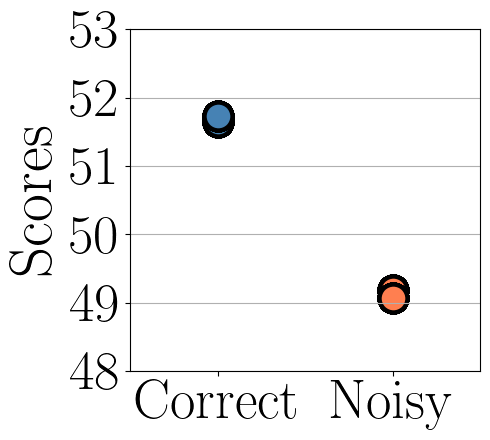

In [37]:
# illustrate scores on a line
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(5,4.5))

rng = np.random.default_rng(0)
idxes_1 = np.arange(0, 50)
idxes_2 = np.arange(400, 450)

ax.scatter(np.ones(len(idxes_1)), scores[idxes_1], c="steelblue", s=400, linewidths=3, edgecolors="black")
ax.scatter(2*np.ones(len(idxes_2)), scores[idxes_2], c="coral", s=400, linewidths=3, edgecolors="black")
plt.xticks([1, 2], ["Correct", "Noisy"])
plt.xlim(0.5, 2.5)
plt.yticks([48, 49, 50, 51, 52, 53])
plt.ylabel("Scores", fontsize=44)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)

plt.tight_layout()
plt.grid(alpha=1, axis='y')
plt.show()